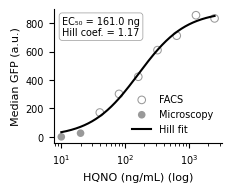

Hill parameters: a=885.36, c=161.02, b=1.17
AIC = 67.0, BIC = 67.6
Calibration saved to hqno_calibration.json and plot to hqno_calibration.pdf


In [2]:
import json
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ——— Configuration ———
INCLUDED_POINTS_CSV = 'hqno_dose_response_included_points.csv'
OUTPUT_PDF          = 'hqno_calibration.pdf'
OUTPUT_PNG          = 'hqno_calibration.png'
OUTPUT_JSON         = 'hqno_calibration.json'

# ——— figure style ———
final_width_cm = 6    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# ——— Model definition ———
def hill_function(x, a, c, b):
    """
    Hill function with zero baseline: a * x**b / (c**b + x**b)
    - a: scaling factor (top)
    - c: half-max concentration (EC50)
    - b: Hill coefficient
    """
    return a * x**b / (c**b + x**b)

# ——— Data loading (from included points CSV) ———
def load_included_points(path: str) -> pd.DataFrame:
    """
    Expects a CSV with at least the columns:
      - 'conc' : numeric concentration (ng)
      - 'GFP'  : response on the microscopy scale
      - 'Source' (optional): e.g., 'Microscopy' or 'FACS (estimated, median)'
    """
    df = pd.read_csv(path)
    # ensure numeric and drop any rows without the needed fields
    df = df.copy()
    df['conc'] = pd.to_numeric(df['conc'], errors='coerce')
    df['GFP']  = pd.to_numeric(df['GFP'],  errors='coerce')
    df = df.dropna(subset=['conc', 'GFP'])
    # Fit requires strictly positive x for the log x-scale
    df = df[df['conc'] > 0]
    return df

def prepare_xy(df: pd.DataFrame, baseline_shift: bool = True):
    """
    Prepare x, y arrays for fitting.
    If baseline_shift is True, shift y so that min(y) == 0.
    This mirrors the zero-baseline Hill form used here.
    """
    x = df['conc'].to_numpy()
    y = df['GFP'].to_numpy()
    if baseline_shift:
        y = y - np.min(y)
    return x, y

# ——— Fitting & metrics ———
def fit_hill_curve(x: np.ndarray, y: np.ndarray):
    # Initial guesses: a ≈ max(y), c ≈ median(x), b ≈ 1
    p0 = [float(np.max(y)), float(np.median(x)), 1.0]
    popt, pcov = curve_fit(hill_function, x, y, p0=p0, maxfev=20000)
    a_fit, c_fit, b_fit = popt

    # Metrics (SSR, AIC, BIC)
    y_pred = hill_function(x, *popt)
    ssr = float(np.sum((y - y_pred) ** 2))
    n, k = x.size, popt.size
    # guard against log(0)
    sigma2 = ssr / max(n, 1)
    aic = n * np.log(max(sigma2, 1e-12)) + 2 * k
    bic = n * np.log(max(sigma2, 1e-12)) + k * np.log(max(n, 1))

    return {'a': a_fit, 'c': c_fit, 'b': b_fit}, aic, bic

# ——— Plotting ———
def plot_hill_fit(x: np.ndarray, y: np.ndarray, params: dict, aic: float, bic: float, raw_df: pd.DataFrame):
    a, c, b = params['a'], params['c'], params['b']
    x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
    y_fit = hill_function(x_fit, a, c, b)

    fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

    # Color for both markers
    teal_color = 'grey'

    # Map source names to clean legend labels and marker styles
    source_label_map = {
        'FACS (estimated, median)': 'FACS',
        'Microscopy': 'Microscopy'
    }

    # If 'Source' exists, show categories with different marker styles
    if 'Source' in raw_df.columns:
        for src, sub in raw_df.groupby('Source'):
            clean_label = source_label_map.get(src, src)
            if src == 'Microscopy':
                # Filled circle for Microscopy
                ax.scatter(sub['conc'], sub['GFP'] - raw_df['GFP'].min(), 
                          s=30, label=clean_label, color=teal_color, 
                          marker='o', edgecolors='none', alpha=0.8)
            elif src == 'FACS (estimated, median)':
                # Open circle for FACS with 0.75 stroke
                ax.scatter(sub['conc'], sub['GFP'] - raw_df['GFP'].min(), 
                          s=30, label=clean_label, facecolors='none', 
                          edgecolors=teal_color, marker='o', linewidths=0.75, alpha=0.8)
    else:
        ax.scatter(x, y, c='black', s=20, label='Data', alpha=0.7)

    ax.plot(x_fit, y_fit, c='black', linewidth=1.5, label='Hill fit')


    ax.set_xscale('log')
    ax.set_xlabel('HQNO (ng/mL) (log)', fontsize=font_size)
    ax.set_ylabel('Median GFP (a.u.)', fontsize=font_size)
    ax.tick_params(labelsize=font_size-1)

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(fontsize=font_size-1, frameon=False, loc='lower right')

    # Add text box with fit parameters
    textstr = f'EC₅₀ = {c:.1f} ng\nHill coef. = {b:.2f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
            fontsize=font_size-1, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))

    plt.tight_layout()
    plt.savefig(OUTPUT_PDF, dpi=300, transparent=True)
    plt.savefig(OUTPUT_PNG, dpi=300, transparent=True)
    plt.show()

# ——— Result container ———
@dataclass
class Calibration:
    method: str           # e.g. "hill"
    params: dict          # {'a':…, 'c':…, 'b':…}
    AIC: float
    BIC: float

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        if self.method == "hill":
            a, c, b = self.params['a'], self.params['c'], self.params['b']
            return hill_function(x, a, c, b)
        else:
            raise ValueError(f"Unknown method {self.method}")

# 1) Load included points and prepare x/y
df_points = load_included_points(INCLUDED_POINTS_CSV)
x_data, y_data = prepare_xy(df_points, baseline_shift=True)

# 2) Fit the Hill function
params, aic, bic = fit_hill_curve(x_data, y_data)

# 3) Plot & save PDF
plot_hill_fit(x_data, y_data, params, aic, bic, raw_df=df_points)

# 4) Package & write JSON
cal = Calibration(method="hill", params=params, AIC=aic, BIC=bic)
with open(OUTPUT_JSON, 'w') as fj:
    json.dump(asdict(cal), fj, indent=2)

# 5) Print summary
print(f"Hill parameters: a={params['a']:.2f}, c={params['c']:.2f}, b={params['b']:.2f}")
print(f"AIC = {aic:.1f}, BIC = {bic:.1f}")
print(f"Calibration saved to {OUTPUT_JSON} and plot to {OUTPUT_PDF}")
